# CAPM Calculations with Exponential Weights #

### CAPM Model using Weighted Linear Regression Model ###

In [1]:
# Import Libraries

# Data Management
import numpy as np
import pandas as pd

# Plots
import matplotlib.pyplot as plt

# Statistics
import statsmodels.api as sm

# Handle Files
import sys
import os

# Import Local Functions
sys.path.append(os.path.abspath("../source"))
from functions import import_daily_financial_data
from capm_toolkit import annual_to_daily_rate

In [2]:
# Weights
def wexp(N, half_life):
    c = np.log(0.5) / half_life
    n = np.array(range(N))
    w = np.exp(c * n)
    return np.flip(w / np.sum(w))

# Create the CAPM Function
def capm_regression(
    excess_stock: pd.Series,
    excess_benchmark: pd.Series,
    window: int = 252,
    WLS: bool = False,
):
    
    X = excess_benchmark
    y = excess_stock
    
    if WLS:
        # Create weights with exponential decay
        weights = window * wexp(window, window/2)
        
        # Fit WLS regression
        model = sm.WLS(y, sm.add_constant(X), weights=weights, missing='drop').fit()
    
    else:
        # Fit OLS regression
        model = sm.OLS(y, sm.add_constant(X), missing='drop').fit()
    
    return model
    
    
def rolling_capm_regression(
    stock_returns: pd.Series,
    benchmark_returns: pd.Series,
    daily_rfr: pd.Series,
    window: int = 252,
    WLS: bool = False,
):

    #Align Data
    df = pd.concat([stock_returns, benchmark_returns, daily_rfr], axis=1)
    df = df.dropna()
    df.columns = ['stock_returns', 'benchmark_returns', 'daily_returns']

    # Compute Excess Returns
    excess_stock = df['stock_returns'] - df['daily_returns']
    excess_benchmark = df['benchmark_returns'] - df['daily_returns']

    # Lists
    alphas, betas, sigma = [], [], []
    p_values_alpha, p_values_beta = [], []
    r_squared = []
    dates = []

    for t in range(window, len(excess_stock)):
        # The variables
        X = excess_benchmark.iloc[t-window:t]
        y = excess_stock.iloc[t-window:t]

        # Create the Model
        model = capm_regression(y, X, window=window, WLS=WLS)

        # Avoid KeyError by checking if params exist
        params = model.params
        pvalues = model.pvalues
        r2 = model.rsquared
        hsigma = (model.resid).std()

        # Append values
        alphas.append(params.iloc[0])
        betas.append(params.iloc[1])
        sigma.append(hsigma)
        p_values_alpha.append(pvalues.iloc[0])
        p_values_beta.append(pvalues.iloc[1])
        r_squared.append(r2)
        dates.append(excess_stock.index[t - 1])  # Last date to calculate betas
            
    parameters = pd.DataFrame({
        'alpha': alphas,
        'beta': betas,
        'sigma': sigma,
        'p_value_alpha': p_values_alpha,
        'p_value_beta': p_values_beta,
        'r_squared': r_squared,
    }, index=pd.Index(dates, name="date"))
    
    return parameters

In [8]:
# Get the important data for the Risk-Free Rate

rfr = pd.read_csv(r"..\additional_data\rfr.csv")
rfr = rfr.set_index('Date')
rfr.index = pd.to_datetime(rfr.index)
rfr.dropna(inplace = True)

rfr

,risk_free_rate
Date,
2015-01-02,0.000083
2015-01-05,0.000080
2015-01-06,0.000077
2015-01-07,0.000077
2015-01-08,0.000080
...,...
2025-05-16,0.000172
2025-05-19,0.000173
2025-05-20,0.000174


In [10]:
# Benchmark Data
data_sp500 = import_daily_financial_data(
    ticker='^GSPC', 
    start_date='2015-01-01', 
    end_date='2025-01-01', 
    returns=True
)

data_sp500

[*********************100%***********************]  1 of 1 completed


Price,close,high,low,open,volume,returns
Date,,,,,,
2015-01-05,2020.579956,2054.439941,2017.339966,2054.439941,3799120000,-0.018447
2015-01-06,2002.609985,2030.250000,1992.439941,2022.150024,4460110000,-0.008933
2015-01-07,2025.900024,2029.609985,2005.550049,2005.550049,3805480000,0.011563
2015-01-08,2062.139893,2064.080078,2030.609985,2030.609985,3934010000,0.017730
2015-01-09,2044.810059,2064.429932,2038.329956,2063.449951,3364140000,-0.008439
...,...,...,...,...,...,...
2024-12-24,6040.040039,6040.100098,5981.439941,5984.629883,1757720000,0.010982
2024-12-26,6037.589844,6049.750000,6007.370117,6024.970215,2904530000,-0.000406
2024-12-27,5970.839844,6006.169922,5932.950195,6006.169922,3159610000,-0.011117


In [11]:
# Stock Data
ticker = 'NVDA'

df_stock = import_daily_financial_data(
        ticker=ticker, 
        start_date='2015-01-01', 
        end_date='2025-01-01', 
        returns=True
    )

df_stock

[*********************100%***********************]  1 of 1 completed


Price,close,high,low,open,volume,returns
Date,,,,,,
2015-01-05,0.474940,0.484539,0.472780,0.483099,197952000,-0.017034
2015-01-06,0.460540,0.476139,0.460060,0.475659,197764000,-0.030788
2015-01-07,0.459340,0.467980,0.457900,0.463900,321808000,-0.002609
2015-01-08,0.476619,0.479499,0.464380,0.464620,283780000,0.036927
2015-01-09,0.478539,0.482139,0.471820,0.478299,209540000,0.004020
...,...,...,...,...,...,...
2024-12-24,140.207108,141.886946,138.637245,139.987127,105157000,0.003930
2024-12-26,139.917130,140.837058,137.717335,139.687155,116205600,-0.002070
2024-12-27,136.997391,139.007216,134.697615,138.537258,170582600,-0.021088


In [12]:
# Calculate the Betas using WLS

betas_wls = rolling_capm_regression(
    df_stock['returns'],
    data_sp500['returns'],
    rfr['risk_free_rate'],
    WLS = True
)

betas_wls

,alpha,beta,sigma,p_value_alpha,p_value_beta,r_squared
date,,,,,,
2016-01-06,0.002497,1.182662,0.018135,0.033794,3.100789e-21,0.301351
2016-01-07,0.002397,1.206589,0.018155,0.041505,2.146704e-22,0.315991
2016-01-08,0.002360,1.211100,0.018114,0.044161,1.234194e-22,0.318988
2016-01-11,0.002385,1.214820,0.018076,0.041311,9.812867e-23,0.320226
2016-01-12,0.002396,1.213521,0.018060,0.039754,1.097646e-22,0.319621
...,...,...,...,...,...,...
2024-12-23,0.001325,2.547249,0.024952,0.395595,3.714918e-31,0.417307
2024-12-24,0.001149,2.522028,0.025011,0.462142,1.216245e-30,0.411782
2024-12-26,0.001149,2.524561,0.025003,0.460772,1.219637e-30,0.411769


In [13]:
# Calculate the Betas using OLS

betas_ols = rolling_capm_regression(
    df_stock['returns'],
    data_sp500['returns'],
    rfr['risk_free_rate'],
    WLS = False,
)

betas_ols

,alpha,beta,sigma,p_value_alpha,p_value_beta,r_squared
date,,,,,,
2016-01-06,0.002006,1.184498,0.018135,0.080918,1.441576e-20,0.292789
2016-01-07,0.001943,1.200202,0.018155,0.091267,4.091676e-21,0.299813
2016-01-08,0.001988,1.196970,0.018114,0.083420,3.986113e-21,0.299958
2016-01-11,0.002058,1.205764,0.018076,0.072560,2.412396e-21,0.302740
2016-01-12,0.002023,1.197498,0.018059,0.077315,5.649220e-21,0.298021
...,...,...,...,...,...,...
2024-12-23,0.002054,2.669811,0.024933,0.194827,1.858356e-31,0.420509
2024-12-24,0.001926,2.659689,0.024987,0.225599,5.636084e-31,0.415371
2024-12-26,0.001953,2.666373,0.024978,0.218670,5.543686e-31,0.415448


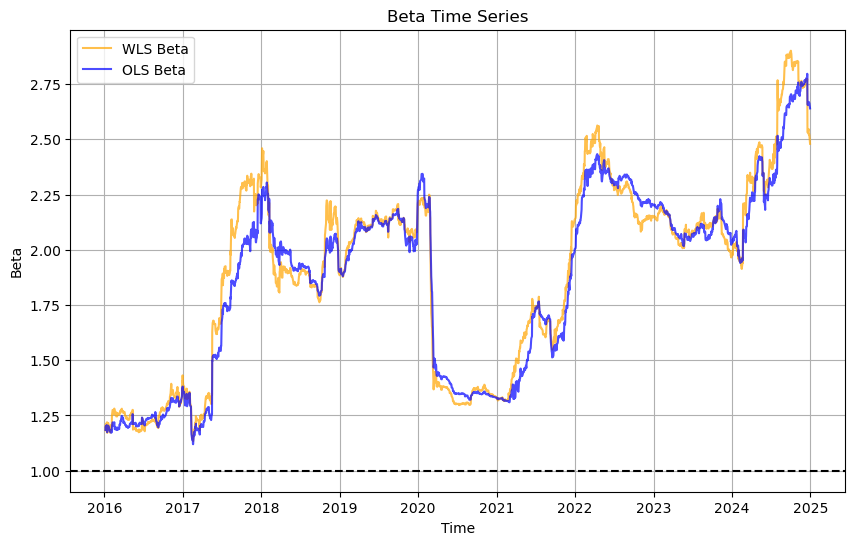

In [15]:
# Create Plot
plt.figure(figsize=(10, 6))
plt.plot(betas_wls['beta'], label='WLS Beta', color='orange', alpha=0.7)
plt.plot(betas_ols['beta'], label='OLS Beta', color='blue', alpha=0.7)
plt.axhline(y=1, color='black', linestyle='dashed')

# Config
plt.title('Beta Time Series')
plt.xlabel('Time')
plt.ylabel('Beta')
plt.legend()

# Show
plt.grid()
plt.show()

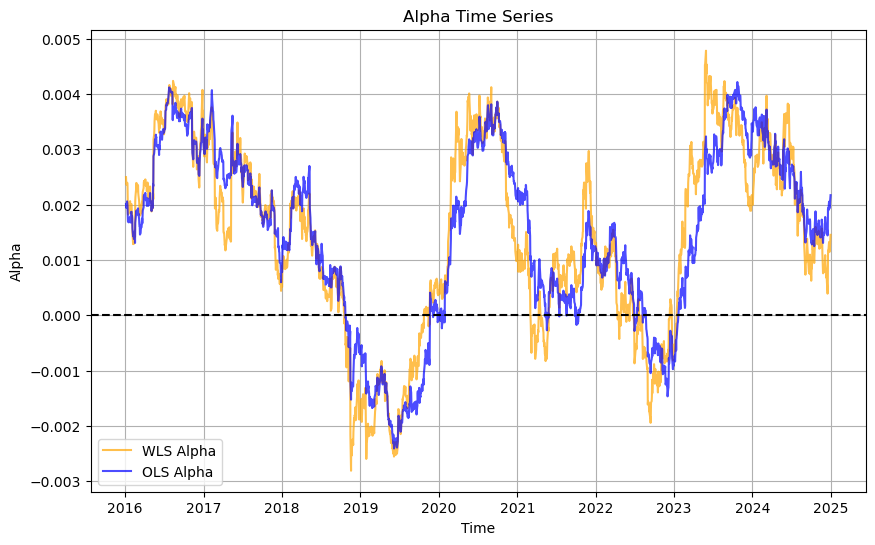

In [16]:
# Create Plot
plt.figure(figsize=(10, 6))
plt.plot(betas_wls['alpha'], label='WLS Alpha', color='orange', alpha=0.7)
plt.plot(betas_ols['alpha'], label='OLS Alpha', color='blue', alpha=0.7)
plt.axhline(y=0, color='black', linestyle='dashed')

# Config
plt.title('Alpha Time Series')
plt.xlabel('Time')
plt.ylabel('Alpha')
plt.legend()

# Show
plt.grid()
plt.show()

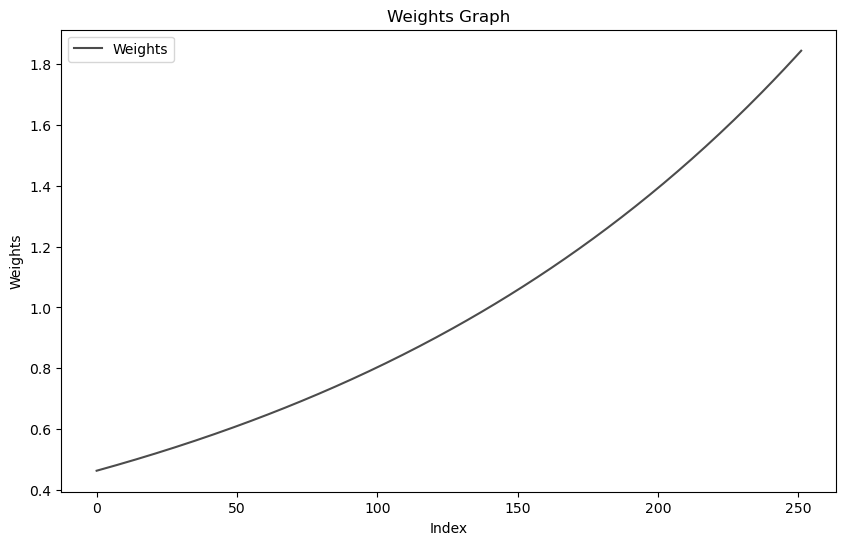

In [18]:
# Create Plot
weights = 252 * wexp(252, 126)

plt.figure(figsize=(10, 6))
plt.plot(weights, label='Weights', color='black', alpha=0.7)

# Config
plt.title('Weights Graph')
plt.xlabel('Index')
plt.ylabel('Weights')
plt.legend()

# Show
plt.show()

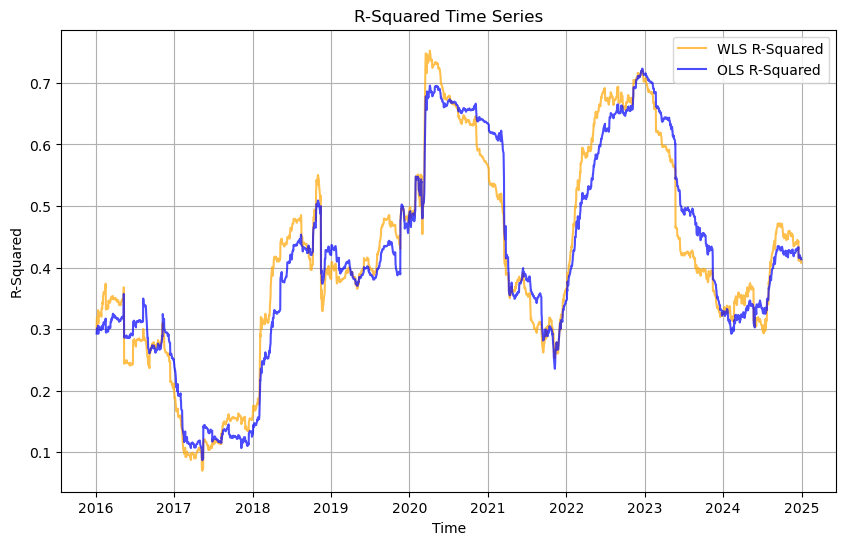

In [20]:
# Create Plot
plt.figure(figsize=(10, 6))
plt.plot(betas_wls['r_squared'], label='WLS R-Squared', color='orange', alpha=0.7)
plt.plot(betas_ols['r_squared'], label='OLS R-Squared', color='blue', alpha=0.7)

# Config
plt.title('R-Squared Time Series')
plt.xlabel('Time')
plt.ylabel('R-Squared')
plt.legend()

# Show
plt.grid()
plt.show()

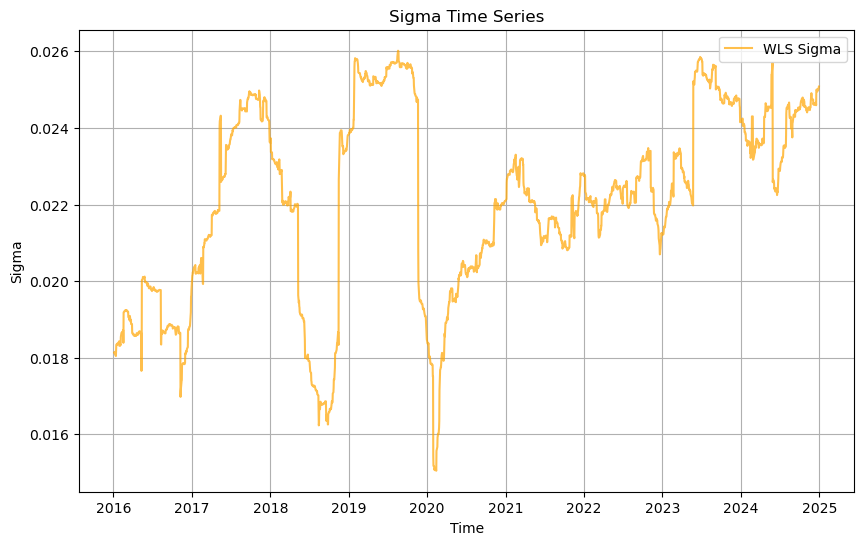

In [21]:
# Create Plot
plt.figure(figsize=(10, 6))
plt.plot(betas_wls['sigma'], label='WLS Sigma', color='orange', alpha=0.7)

# Config
plt.title('Sigma Time Series')
plt.xlabel('Time')
plt.ylabel('Sigma')
plt.legend()

# Show
plt.grid()
plt.show()

In [22]:
# Compute the Factor Contribution to Returns
def compute_factor_contributions(factor_returns, betas):
    # Multiply Elements
    contribution = (factor_returns * betas)

    return contribution

# Compute the Residual Returns
def compute_residual_returns(stock_excess_returns, factor_contributions):
    return stock_excess_returns - factor_contributions

In [23]:
# Create the Residual Returns DF

capm_returns_df = pd.DataFrame(index=betas_wls.index)

capm_returns_df['stock_excess_returns'] = df_stock['returns'] - rfr['risk_free_rate']
capm_returns_df['market_excess_returns'] = data_sp500['returns'] - rfr['risk_free_rate']
capm_returns_df['betas'] = betas_wls['beta']

capm_returns_df['factor_returns'] = compute_factor_contributions(
    capm_returns_df['market_excess_returns'], 
    capm_returns_df['betas']
)

capm_returns_df['residual_returns'] = compute_residual_returns(
    capm_returns_df['stock_excess_returns'],
    capm_returns_df['factor_returns']
)

capm_returns_df

,stock_excess_returns,market_excess_returns,betas,factor_returns,residual_returns
date,,,,,
2016-01-06,-0.042315,-0.013288,1.182662,-0.015715,-0.026600
2016-01-07,-0.040537,-0.024071,1.206589,-0.029043,-0.011494
2016-01-08,-0.021784,-0.010981,1.211100,-0.013299,-0.008484
2016-01-11,0.001601,0.000768,1.214820,0.000933,0.000668
2016-01-12,0.016623,0.007689,1.213521,0.009331,0.007292
...,...,...,...,...,...
2024-12-23,0.036054,0.007083,2.547249,0.018042,0.018013
2024-12-24,0.003752,0.010804,2.522028,0.027248,-0.023496
2024-12-26,-0.002248,-0.000583,2.524561,-0.001473,-0.000775


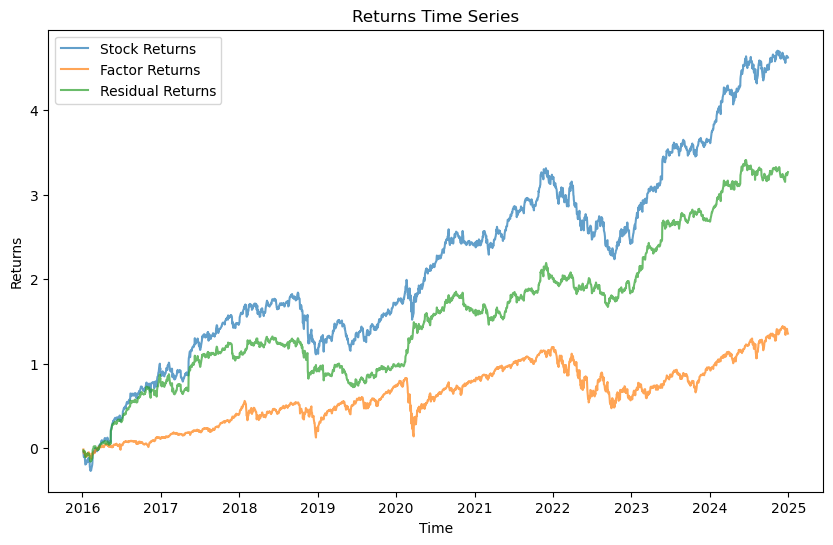

In [24]:
# Create Plot

plt.figure(figsize=(10, 6))
plt.plot(capm_returns_df['stock_excess_returns'].cumsum(), label='Stock Returns', alpha=0.7)
plt.plot(capm_returns_df['factor_returns'].cumsum(), label='Factor Returns', alpha=0.7)
plt.plot(capm_returns_df['residual_returns'].cumsum(), label='Residual Returns', alpha=0.7)

# Config
plt.title('Returns Time Series')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()

# Show
plt.show()